# Pretrained ResNet model visualization

In this notebook we will show how to load a pretrained ResNet-18 model, to visualize it's structure, weights and
propagate a sample image to show it's contents

The notebook doesn't need CUDA support and needs the following rocks:
```
luarocks install optnet
```

In [28]:
nn = require 'nn'
graphgen = require 'optnet.graphgen'

In [29]:
-- download ResNet-18 model (47MB)
local name = 'resnet-18-cleared.t7'
local url = 'https://www.dropbox.com/s/76m5w4dmutgmou3/'..name

if not paths.filep(name) then os.execute('wget '..url) end

net = torch.load(name)

## Show text representation

In [3]:
print(tostring(net))

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> output]
  (1): nn.SpatialConvolution(3 -> 64, 7x7, 2,2, 3,3) without bias
  (2): nn.SpatialBatchNormalization
  (3): nn.ReLU
  (4): nn.SpatialMaxPooling(3x3, 2,2, 1,1)
  (5): nn.Sequential {
    [input -> (1) -> (2) -> output]
    (1): nn.Sequential {
      [input -> (1) -> (2) -> (3) -> output]
      (1): nn.ConcatTable {
        input
          |`-> (1): nn.Sequential {
          |      [input -> (1) -> (2) -> (3) -> (4) -> (5) -> output]
          |      (1): nn.SpatialConvolution(64 -> 64, 3x3, 1,1, 1,1) without bias
          |      (2): nn.SpatialBatchNormalization
          |      (3): nn.ReLU
          |      (4): nn.SpatialConvolution(64 -> 64, 3x3, 1,1, 1,1) without bias
          |      (5): nn.SpatialBatchNormalization
          |    }
          |`-> (2): nn.Identity
           ... -> output
      }
      (2): nn.CAddTable
      (3): nn.ReLU
    }
    (2): nn.Sequentia

 |      (2): nn.SpatialBatchNormalization
          |      (3): nn.ReLU
          |      (4): nn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1) without bias
          |      (5): nn.SpatialBatchNormalization
          |    }
          |`-> (2): nn.Identity
           ... -> output
      }
      (2): nn.CAddTable
      (3): nn.ReLU
    }
  }
  (8): nn.Sequential {
    [input -> (1) -> (2) -> output]
    (1): nn.Sequential {
      [input -> (1) -> (2) -> (3) -> output]
      (1): nn.ConcatTable {
        input
          |`-> (1): nn.Sequential {
          |      [input -> (1) -> (2) -> (3) -> (4) -> (5) -> output]
          |      (1): nn.SpatialConvolution(256 -> 512, 3x3, 2,2, 1,1) without bias
          |      (2): nn.SpatialBatchNormalization
          |      (3): nn.ReLU
          |      (4): nn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1) without bias
          |      (5): nn.SpatialBatchNormalization
          |    }
          |`-> (2): nn.SpatialConvolution(256 -> 512, 1x1, 2,2) 

## Show network graph

In [10]:
-- optnet needs to propagate through the network to generate the graph
-- so we create a dummy input for it
local input = torch.randn(1,3,224,224):float()

-- we will generate svg image from our graph
local svgname = paths.tmpname() .. '.svg'
graph.graphvizFile(graphgen(net,input), 'dot', svgname)
itorch.svg(svgname)

## Visualize first layer filters

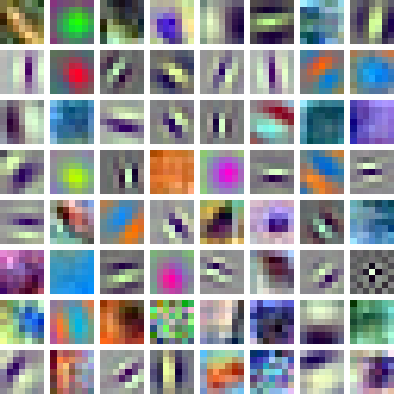

In [26]:
local w = net:get(1).weight
local im = image.toDisplayTensor{input=w, padding=1, nrow=8, scaleeach=true}
itorch.image(image.scale(im, 400, 400, 'simple'))

# Test the network with a random image from wikipedia

In [32]:
local image_url = 'http://upload.wikimedia.org/wikipedia/commons/e/e9/Goldfish3.jpg'
image_name = paths.basename(image_url)
if not paths.filep(image_name) then os.execute('wget '..image_url)   end

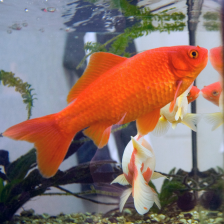

In [35]:
-- Rescales and normalizes the image
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')
  -- subtract imagenet mean and divide by std
  for i=1,3 do im3[i]:add(-img_mean.mean[i]):div(img_mean.std[i]) end
  return im3
end

local transform = {
   mean = {
      0.48462227599918,
      0.45624044862054,
      0.40588363755159,
   },
   std = {
      0.22889466674951,
      0.22446679341259,
      0.22495548344775,
   }
}

local im = image.load(image_name)
I = preprocess(im, transform):float()
itorch.image(I)

In [48]:
os.execute('wget https://raw.githubusercontent.com/szagoruyko/torch-opencv-demos/master/imagenet_classification/synset.t7')
local synset_words = torch.load('synset.t7', 'ascii')

local _,classes = net:forward(I:view(1,3,224,224)):view(-1):sort(true)
for i=1,5 do
  print('predicted class '..tostring(i)..': ', synset_words[classes[i] ])
end

predicted class 1: 	goldfish, Carassius auratus	
predicted class 2: 	tench, Tinca tinca	
predicted class 3: 	gar, garfish, garpike, billfish, Lepisosteus osseus	
predicted class 4: 	eft	
predicted class 5: 	axolotl, mud puppy, Ambystoma mexicanum	
